CLIP + Annoy + Gradio  实现文搜图和图搜图 跨模态(cross-modal)检索

# 0. 前置工具函数

In [1]:
import os
import glob
import random
import shutil
from tqdm import tqdm
from PIL import Image
import numpy as np
import argparse
from matplotlib import pyplot as plt
import sys
import torch
import torchvision
import timm
import clip

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 设置模型参数
def get_args_paeser():
    parser = argparse.ArgumentParser('image search task', add_help=False)
    # Model parameters
    parser.add_argument('--input_size', type=int, default=128, help='image size')
    parser.add_argument('--model_name', type=str, default='resnet50', help='model name')  # resnet50 or clip
    parser.add_argument('--dataset_dir', type=str, default='train', help='path to train dataset')
    parser.add_argument('--test_dataset_dir', type=str, default='query', help='path to train dataset')
    parser.add_argument('--output_path', type=str, default='output', help='path to output files')
    parser.add_argument('--feature_dict_file', type=str, default='corpus_feature_dict.npy', help='path to save image feature')
    parser.add_argument('--topk', type=int, default=7)
    parser.add_argument('--mode', type=str, default='extract') # extract or predict
    return parser

# 使用resnet提取单张图像特征
def extract_feature_single(args, model, file):
    img_rgb = Image.open(file).convert('RGB')
    image = img_rgb.resize((args.input_size, args.input_size))
    image = torchvision.transforms.ToTensor()(image)
    trainset_mean = [0.34586244, 0.32885485, 0.29705444]
    trainset_std = [0.31485778, 0.30461005, 0.30083735]
    image = torchvision.transforms.Normalize(trainset_mean, trainset_std)(image)
    with torch.no_grad():
        features = model.forward_features(image.unsqueeze(0))
        vec = model.global_pool(features)
        vec = vec.squeeze().numpy()
    img_rgb.close()
    return vec

# 使用clip提取单张图像特征
def extract_feature_by_CLIP(model, preprocess, file):
    image = preprocess(Image.open(file)).unsqueeze(0).to(device)
    with torch.no_grad():
        vec = model.encode_image(image)
    return vec.squeeze().cpu().numpy()

# 提取文件夹test_image_path下的所有图像的特征，存入字典allVectors中{image_name : vector}
def extract_image_features(args, model, test_image_path='', preprocess=None):
    allVectors = {}
    for image_file in tqdm(glob.glob(os.path.join(test_image_path, "*", '*.jpg'))):  # 取每张图片进行提取特征
        if args.model_name == 'clip':
            allVectors[image_file] = extract_feature_by_CLIP(model, preprocess, image_file)
        else:
            allVectors[image_file] = extract_feature_single(args, model, image_file)
    os.makedirs(os.path.join(args.output_path, args.model_name), exist_ok=True)
    np.save(os.path.join(args.output_path, args.model_name, args.feature_dict_file), allVectors)
    return allVectors

# 使用clip提取单个文本特征
def extract_text_feature_by_CLIP(model, preprocess, text):
    text = clip.tokenize(text).to(device)
    with torch.no_grad():
        vec = model.encode_text(text)
    return vec.squeeze().cpu().numpy()        
    
# 计算vector_dict字典内的特征余弦相似度
def getSimilarityMatrix(vector_dict):
    v = np.array(list(vector_dict.values())) # [NUM, H]
    numerator = np.matmul(v, v.T) # [NUM, NUM]
    denominator = np.matmul(np.linalg.norm(v, axis=1, keepdims=True), np.linalg.norm(v, axis=1, keepdims=True).T) # [NUM,NUM]
    sim = numerator / denominator  # 余弦相似度矩阵
    keys = list(vector_dict.keys())  # 图片文件名
    return sim, keys


def setAxes(ax, image, query=False, **kwargs):
    value = kwargs.get('value', None)
    if query:
        ax.set_xlabel('Query Image\n{0}'.format(image), fontsize=12)
        ax.xaxis.label.set_color('red')
    else:
        ax.set_xlabel('score={1:1.3f}\n{0}'.format(image, value), fontsize=12)
        ax.xaxis.label.set_color('blue')
    ax.set_xticks([])
    ax.set_yticks([])

def plotImageSimilarImages(args, image, simImages, simValues, numRow=1, numCol=4):
    fig = plt.figure()
    # 设置w和h
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle(f"use engine model: {args.model_name}", fontsize=35)
    for j in range(0, numRow * numCol):
        ax = []
        if j == 0:
            img = Image.open(image)
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image.split(os.sep)[-1], query=True)
        else:
            img = Image.open(simImages[j - 1])
            ax = fig.add_subplot(numRow, numCol, j + 1)
            # setAxes(ax[-1], simImages[j - 1].split(os.sep)[-1], value=simValues[j - 1])
            ax.set_xlabel(simImages[j - 1].split(os.sep)[-1])  # 设置横轴标签
            ax.set_title(f"Similarity: {simValues[j - 1]:.2f}")  # 设置图像标题
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    fig.savefig(f"{args.output_path}/{args.model_name}_search_top_{args.topk}_{image.split(os.sep)[-1].split('.')[0]}.png")
    plt.show()

def plotTextSimilarImages(args, text, simImages, simValues, numRow=1, numCol=4):
    fig = plt.figure()
    # 设置w和h
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle(f"use engine model: {args.model_name}", fontsize=35)
    for j in range(0, numRow * numCol):
        ax = []
        if j == 0:
            ax = fig.add_subplot(numRow, numCol, 1)
            ax.set_xlabel(f"Query Text:\n'{text}'", fontsize=12)
            ax.xaxis.label.set_color('red')
            ax.imshow(np.zeros((1,1)))  # 显示一个空图像（文本）
        else:
            ax = fig.add_subplot(numRow, numCol, j + 1)
            ax.set_xlabel(simImages[j - 1].split(os.sep)[-1])  # 设置横轴标签
            ax.set_title(f"Similarity: {simValues[j - 1]:.2f}")  # 设置图像
            img = Image.open(simImages[j - 1])
            img = img.convert('RGB')
            plt.imshow(img)
            img.close()
    fig.savefig(f"{args.output_path}/{args.model_name}_search_top_{args.topk}_{text.split(' ')[0]}.png")
    plt.show()


# 1.特征提取

In [9]:
import numpy as np
from tqdm import tqdm
import pickle
import os

# 1. 加载clip模型
args = get_args_paeser().parse_args(args=['--model_name', 'clip', '--mode', 'extract'])  # mode = extract
# args = get_args_paeser().parse_args(args=['--model_name', 'clip', '--mode', 'predict'])  # mode = predict
moedl, preprocess = None, None
model, preprocess = clip.load("ViT-B/32", device=device)


# 2. 提取图片特征

# 图形特征提取(将所有图像的特征储存为{image_path : feature_vector}.npy)
allVectors = extract_image_features(args, model, test_image_path=args.dataset_dir, preprocess=preprocess)


img_name_list = []
img_feature_list = []

for image_file in tqdm(glob.glob(os.path.join(args.dataset_dir, "*", '*.jpg'))):  # 取每张图片进行提取特征
    image = preprocess(Image.open(image_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        vec = model.encode_image(image).squeeze().cpu().numpy()
    img_name_list.append(image_file)
    img_feature_list.append(vec)

# 3. 将图片名称和图片特征保存为pkl格式
f = open("img_feature_list.pkl", 'wb')
pickle.dump(img_feature_list, f)
f.close()

g = open("img_name_list.pkl", 'wb')
pickle.dump(img_name_list, g)
g.close()

100%|██████████| 1000/1000 [00:37<00:00, 26.65it/s]


# 2. 建树存储

使用Annoy技术对图片特征数据构建索引，及建树<br>
本实验构建了10棵二叉树，此时将得到 index_to_name_dict.pkl 和 img_feature_list.ann 两个文件，分别保存图片索引Id与名称的映射数据，和图片特征的二叉树结构信息。


In [11]:
# encoding:utf-8
from annoy import AnnoyIndex
import pickle
import numpy as np
np.random.seed(20200601)
import sys, time
from tqdm import tqdm

def build_ann(name_path=None, \
       vec_path=None, \
       index_to_name_dict_path=None, \
       ann_path=None, \
       dim=64, \
       n_trees=10):

    name_path = open(name_path, 'rb')
    vec_path = open(vec_path, 'rb')
    img_name_list = pickle.load(name_path)
    img_vec_list = pickle.load(vec_path)
    

    ann = AnnoyIndex(dim)
    idx = 0
    batch_size = 100 * 10000
    index_to_name_dict = {}
    

    for name, vec in tqdm(zip(img_name_list, img_vec_list)):
        ann.add_item(idx, vec)
        index_to_name_dict[idx] = name

        idx += 1
        if idx % batch_size == 0:
            print("%s00w" % (int(idx/batch_size)))

    print("Add items Done!\nStart building trees")

    ann.build(n_trees)
    print("Build Trees Done!")
    
    ann.save(ann_path)
    print("Save ann to %s Done!" % (ann_path))

    fd = open(index_to_name_dict_path, 'wb')
    pickle.dump(index_to_name_dict, fd)
    fd.close()
    print("Saving index_to_name mapping Done!")


if __name__ == '__main__':
    name_path = "img_name_list.pkl"
    vec_path = "img_feature_list.pkl"
    index_to_name_dict_path = "index_to_name_dict.pkl"
    ann_path = "img_feature_list.ann"
    dim = 512
    n_trees = 10

    build_ann(name_path=name_path, \
        vec_path=vec_path, \
        index_to_name_dict_path=index_to_name_dict_path, \
        ann_path=ann_path, \
        dim=dim, \
        n_trees=n_trees)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4072\4192653737.py:22: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  ann = AnnoyIndex(dim)
1000it [00:00, 14596.55it/s]

Add items Done!
Start building trees
Build Trees Done!
Save ann to img_feature_list.ann Done!
Saving index_to_name mapping Done!


# 3. 图搜图/文搜图

输入一张图片特征数据，检索并返回最相似的Top-9张图片<br>
本实验以idx=126为例进行测试，idx取值范围为[0, 5129]。

输入一张图像或一段文本数据，利用clip提取为vec特征

In [2]:
# 1. 加载clip模型
args = get_args_paeser().parse_args(args=['--model_name', 'clip', '--mode', 'extract'])  # mode = extract
# args = get_args_paeser().parse_args(args=['--model_name', 'clip', '--mode', 'predict'])  # mode = predict
moedl, preprocess = None, None
model, preprocess = clip.load("ViT-B/32", device=device)

query_modal = ["image", "text"]  
query_modal = query_modal[1]  # 设置query是一张图还是一段话

if query_modal == "image":  # 优先检索图像
    query_image = "query/000000009769.jpg"
    img_vec = extract_feature_by_CLIP(model, preprocess, query_image)
    query_name = query_image
    query_vec = img_vec
elif query_modal == "text":
    query_text = "a cute doggy playing with human"
    text_vec = extract_text_feature_by_CLIP(model, preprocess, query_text)
    query_name = query_text
    query_vec = text_vec

text
a cute doggy playing with human


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16392\163474589.py:10: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  ann = AnnoyIndex(dim)


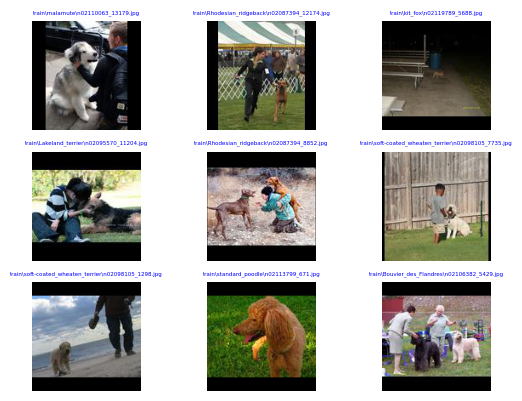

In [3]:
from annoy import AnnoyIndex
import numpy as np
np.random.seed(20200601)
import pickle
import sys
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

def load_ann(ann_path=None, index_to_name_dict_path=None, dim=64):
    ann = AnnoyIndex(dim)
    ann.load(ann_path)

    with open(index_to_name_dict_path, 'rb') as f:
        index_to_name_dict = pickle.load(f)
    return ann, index_to_name_dict


def query_ann(ann=None, index_to_name_dict=None, query_vec=None, topN=None):
    topN_item_idx_list = ann.get_nns_by_vector(query_vec, topN)

    topN_item_id_list = []

    for idx in topN_item_idx_list:
        item_id = index_to_name_dict[idx]
        topN_item_id_list.append(item_id)

    return topN_item_id_list


if __name__ == '__main__':
    index_to_name_dict_path = "index_to_name_dict.pkl"
    ann_path = "img_feature_list.ann"
    name_path = "img_name_list.pkl"
    vec_path = "img_feature_list.pkl"
    dim = 512
    topN = 9
    n_trees = 10
    
    name_path = open(name_path, 'rb')
    vec_path = open(vec_path, 'rb')
    img_name_list = pickle.load(name_path)
    img_vec_list = pickle.load(vec_path)

    print (query_modal)
    print (query_name)
    
    ann, index_to_name_dict = load_ann(ann_path=ann_path, index_to_name_dict_path=index_to_name_dict_path, dim=dim)
        
    topN_item_list = query_ann(ann=ann, index_to_name_dict=index_to_name_dict, query_vec=query_vec, topN=topN)

    if query_modal == "image":  # 如果是图片查询
        print("query_image: \n")
        fig, axes = plt.subplots(1, 1)
        query_image = mpimg.imread(query_name)
        axes.imshow(query_image/255)
        axes.axis('off')
        axes.axis('off')
        axes.set_title('%s' % query_name, fontsize=8, color='r')

    # Top-9 相似图片
    fig, axes = plt.subplots(3, 3)
    for idx, img_path in enumerate(topN_item_list):

        i = idx % 3   # Get subplot row
        j = idx // 3  # Get subplot column
        image = mpimg.imread(img_path)
        axes[i, j].imshow(image/255)
        axes[i, j].axis('off')
        axes[i, j].axis('off')

        axes[i, j].set_title('%s' % img_path, fontsize=4, color='b')


# 4. Web端部署

In [2]:
import gradio as gr
from annoy import AnnoyIndex
import numpy as np
import pickle
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# 1. 加载clip模型
model, preprocess = clip.load("ViT-B/32", device=device)

def load_ann(ann_path=None, index_to_name_dict_path=None, dim=64):
    ann = AnnoyIndex(dim, metric='angular')
    ann.load(ann_path)
    with open(index_to_name_dict_path, 'rb') as f:
        index_to_name_dict = pickle.load(f)
    return ann, index_to_name_dict

def query_ann(ann=None, index_to_name_dict=None, query_vec=None, topN=None):
    topN_item_idx_list = ann.get_nns_by_vector(query_vec, topN)
    topN_item_id_list = []
    for idx in topN_item_idx_list:
        item_id = index_to_name_dict[idx]
        topN_item_id_list.append(item_id)
    return topN_item_id_list

# 使用clip提取单张图像特征
def extract_feature_by_CLIP(model, preprocess, file):
    # 因为file传入的是ndarray类型所以重写extract_feature_by_CLIP方法转换为PIL
    image = preprocess(Image.fromarray(file)).unsqueeze(0).to(device)  
    with torch.no_grad():
        vec = model.encode_image(image)
    return vec.squeeze().cpu().numpy()

# 使用clip提取单个文本特征
def extract_text_feature_by_CLIP(model, preprocess, text):
    text = clip.tokenize(text).to(device)
    with torch.no_grad():
        vec = model.encode_text(text)
    return vec.squeeze().cpu().numpy()        

def search_similarity(query_modal, query_name):
    index_to_name_dict_path = "index_to_name_dict.pkl"
    ann_path = "img_feature_list.ann"
    name_path = "img_name_list.pkl"
    vec_path = "img_feature_list.pkl"
    dim = 512
    topN = 9

    name_path = open(name_path, 'rb')
    vec_path = open(vec_path, 'rb')

    ann, index_to_name_dict = load_ann(ann_path=ann_path, index_to_name_dict_path=index_to_name_dict_path, dim=dim)

    if query_modal == "image":  # 检索图像
        query_vec = extract_feature_by_CLIP(model, preprocess, query_name)
    elif query_modal == "text":  # 检索文字
        query_vec = extract_text_feature_by_CLIP(model, preprocess, query_name)

    topN_item_list = query_ann(ann=ann, index_to_name_dict=index_to_name_dict, query_vec=query_vec, topN=topN)
    
    return topN_item_list

def plot_images(topN_item_list):
    fig, axes = plt.subplots(3, 3)
    for idx, img_path in enumerate(topN_item_list):
        i = idx % 3   # Get subplot row
        j = idx // 3  # Get subplot column
        image = mpimg.imread(img_path)
        axes[i, j].imshow(image/255)
        axes[i, j].axis('off')
        axes[i, j].set_title('%s' % img_path, fontsize=4, color='b')
    
    # Save the concatenated image to a file
    result_image_path = "result_image.png"
    plt.savefig(result_image_path)
    plt.close()
    return mpimg.imread(result_image_path)

def search_text(x):
    topN_item_list = search_similarity(query_modal="text", query_name=x)
    return plot_images(topN_item_list)

def search_image(x):
    topN_item_list = search_similarity(query_modal="image", query_name=x)
    return plot_images(topN_item_list)

with gr.Blocks() as demo:
    #用markdown语法编辑输出一段话
    gr.Markdown("# Image Search Engine")
    #用markdown语法编辑输出一段话
    gr.Markdown("Search images by Image or by Text using this demo.")
    # 设置tab选项卡
    with gr.Tab("Search Text"):
        #Blocks特有组件，设置所有子组件按垂直排列
        with gr.Column():
            text_input = gr.Textbox(label="Query Text", info="请输入想要检索图片的文字描述 例如：a cute doggy")
            text_output = gr.Image(label="TOP-9 Search Result")
            text_button = gr.Button("Searching")
    with gr.Tab("Search Image"):
        #Blocks特有组件，设置所有子组件按水平排列
        with gr.Row():
            image_input = gr.Image(label="Query Image")
            image_output = gr.Image(label="TOP-9 Search Result")
        image_button = gr.Button("Searching")
    #设置折叠内容
    with gr.Accordion("Open for More!"):
        gr.Markdown("Copyright © 2023<br>ZhengRog Yue CUMTB<br>---<br>For any questions, please contact me at yzr_cumtb@163.com.")
    # 设置响应函数
    text_button.click(search_text, inputs=text_input, outputs=text_output)
    image_button.click(search_image, inputs=image_input, outputs=image_output)

if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
